# Data Wrangling

In [3]:
# import packages, get API KEY from .env file.
import os
from dotenv import load_dotenv
import requests
from collections import namedtuple
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

load_dotenv('.env')

API_KEY = os.getenv('NASDAQ_API_KEY')

In [4]:
# Call the Nasdaq API and get data in the form of a JSON.

url = 'https://data.nasdaq.com/api/v3/datasets/FSE/AFX_X?api_key=' + API_KEY
r = requests.get(url)
json_data = r.json()

In [26]:
#Create a list for opening prices from 2000 to 2015, and another list for the dates. Then convert to dataframe.

opening_prices = []
dates = []

for data in json_data['dataset']['data']:
    year = datetime.strptime(data[0],'%Y-%m-%d').year
    if year < 2016:
        opening_prices.append(data[1])
        dates.append(data[0])

data_before_2016 = pd.DataFrame.from_dict({'date': dates, 'open': opening_prices}).set_index('date')
data_before_2016.index = pd.to_datetime(data_before_2016.index)
        
data_before_2016.head()

,open
date,
2015-12-31,NaN
2015-12-30,28.39
2015-12-29,28.03
2015-12-28,28.98
2015-12-25,NaN


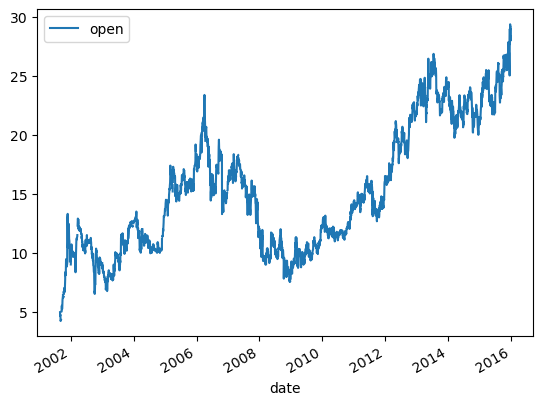

In [30]:
data_before_2016.plot()
plt.show()